<a href="https://colab.research.google.com/github/jaiieth/Bootcamp_Project/blob/main/Exploratory%20Data%20Analysis/Data_Transformation_NYC_Fligths_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC 2013 FLIGHTS ANALYSIS


## Install / Load libraries

In [ ]:
install.packages(c("nycflights13","tidyverse"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(nycflights13)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Using glimpse(), head() and tail() to preview data


In [ ]:
glimpse(flights)
head(flights)
tail(flights)

## 1.Top 10 routes from NYC that has the longest distance
- Distance
- Minimum flight time



Warning message in min(air_time, na.rm = T):
“no non-missing arguments to min; returning Inf”


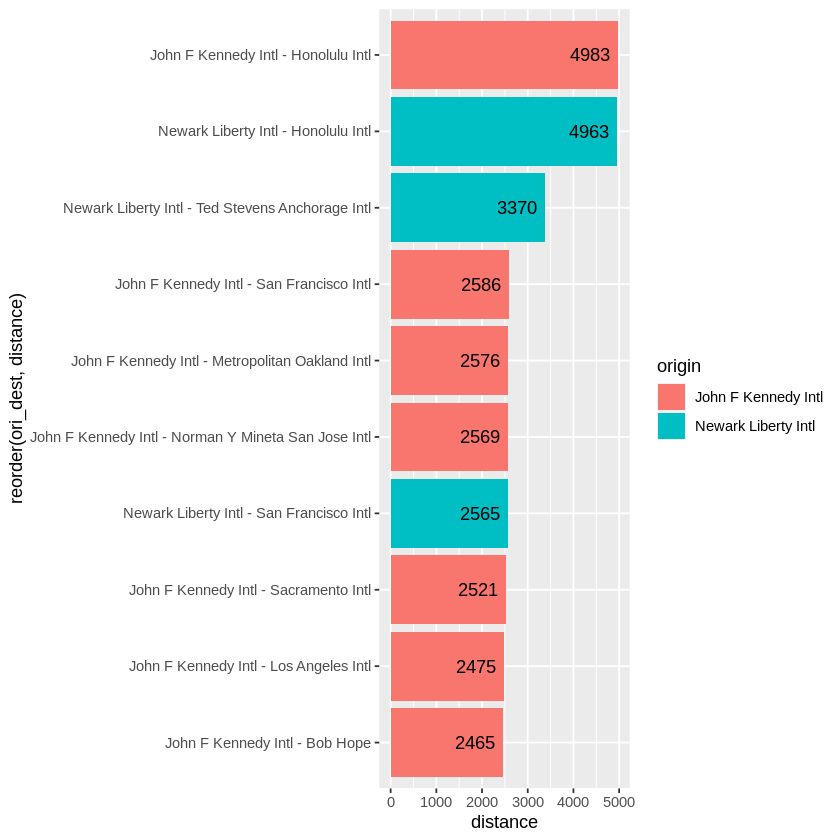

In [ ]:
longest_routes <- flights %>%
  inner_join(airports,by=c('origin'='faa')) %>%
  inner_join(airports,by=c('dest'='faa')) %>%
  group_by(origin=name.x,destination=name.y,distance) %>%
  summarise(min_air_time= min(air_time,na.rm=T),.groups = "keep") %>%
  mutate(ori_dest = paste(origin,destination,sep=" - ")) %>%
  arrange(desc(distance)) %>%
  head(10)

  longest_routes %>%
    ggplot(aes(distance,reorder(ori_dest,distance),fill=origin))+
    geom_col()+
    geom_text(aes(label=distance),hjust=1.2)

Summary : 

> Flight from John F Kennedy Intl to Honolulu Intl has the longest distance at 4,983 miles.
>>The minimum flight time of this route is 580 minutes.








## 2.Top 5 airlines that has the highest number of flight time from NYC in the first quarter of 2013
- Total flight time
- Total flights
- Average flight time

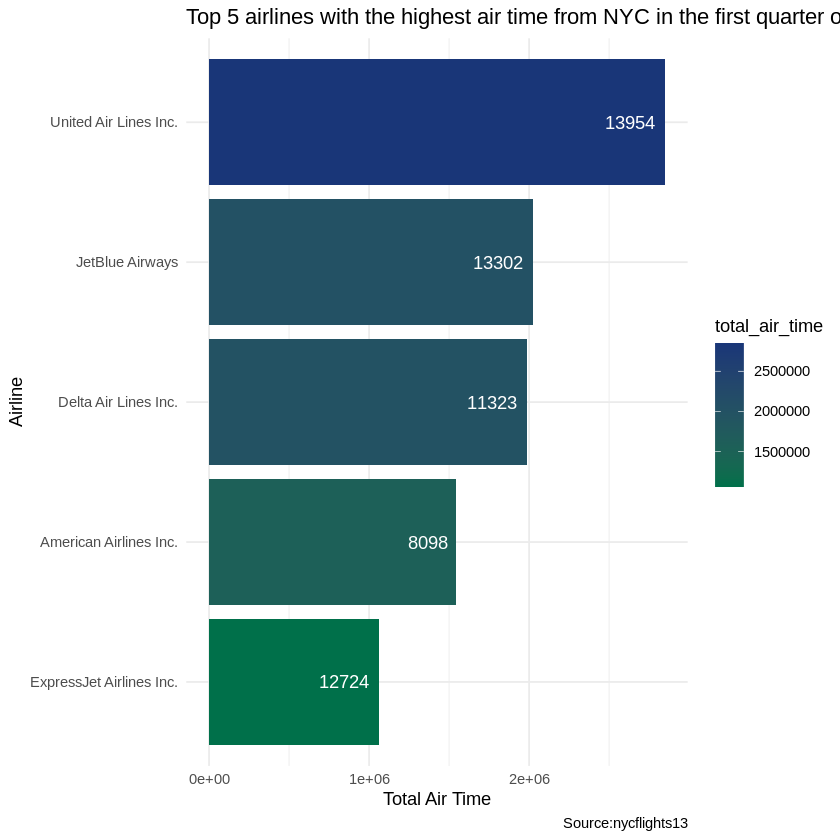

In [ ]:
flights %>%
  inner_join(airlines, by = 'carrier') %>%
  filter(between(month,1,3)) %>%
  select(airline = name,air_time) %>%
  group_by(airline) %>%
  summarise(total_air_time = sum(air_time,na.rm=T),
            n= n(),
            avg_air_time = round(total_air_time/n,2)) %>%
  arrange(desc(total_air_time)) %>%
  head(5) %>%
  ggplot(aes(total_air_time,reorder(airline,total_air_time),fill=total_air_time))+
  geom_col()+
  geom_text(aes(x=total_air_time,label=n),hjust=1.2,color='white')+
  theme_minimal()+
  scale_fill_gradient(low="#00704A",high="#193678")+
  labs(x='Total Air Time',y='Airline',title='Top 5 airlines with the highest air time from NYC in the first quarter of 2013',caption='Source:nycflights13')

Summary : 
> United airline had the most flights in the 1st quarter of 2013 at 13,954 flights and had an average flight time of approximately 204 minutes each

## 3.What time of the day had the most delays?
- More than 15 minutes delay.
- % of delayed flights

In [ ]:
delay_hour <- flights %>%
  group_by(hour) %>%
  summarise(total_flights=n(),
            delayed_flights = sum(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),
            rate = round(mean(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),3))%>%
  arrange(desc(delayed_flights))

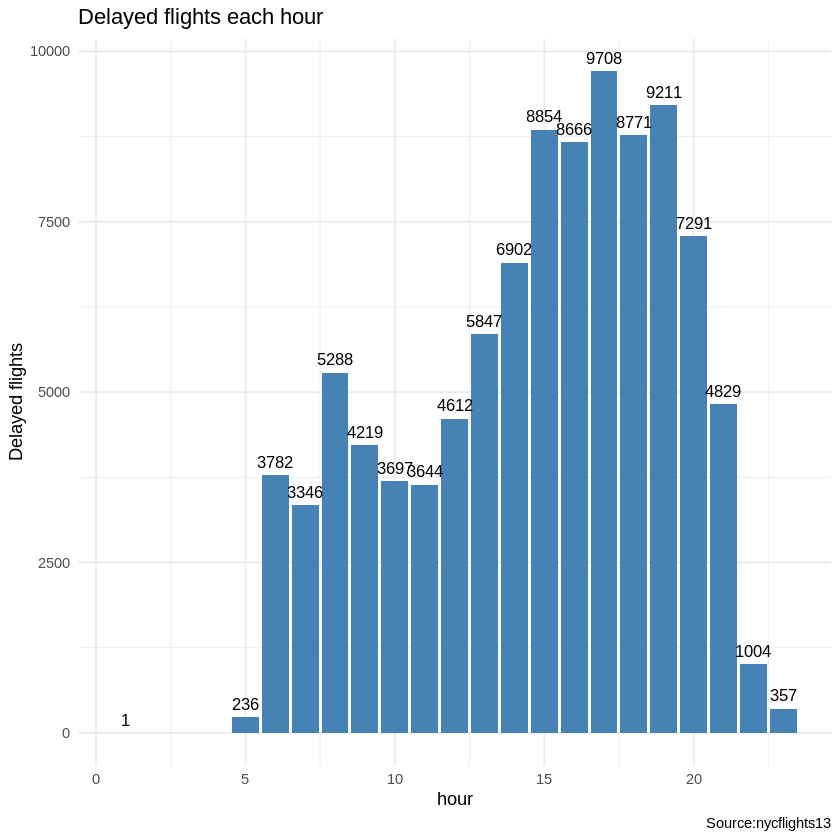

In [ ]:
ggplot(delay_hour) +
  geom_col(aes(hour,delayed_flights),fill="steelblue") +
  geom_text(aes(y=delayed_flights, x=hour,label=delayed_flights),vjust=-.6, 
            color="black", size=3.5)+
  theme_minimal()+
  labs(title='Delayed flights each hour',
  y = 'Delayed flights',
  caption='Source:nycflights13')

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



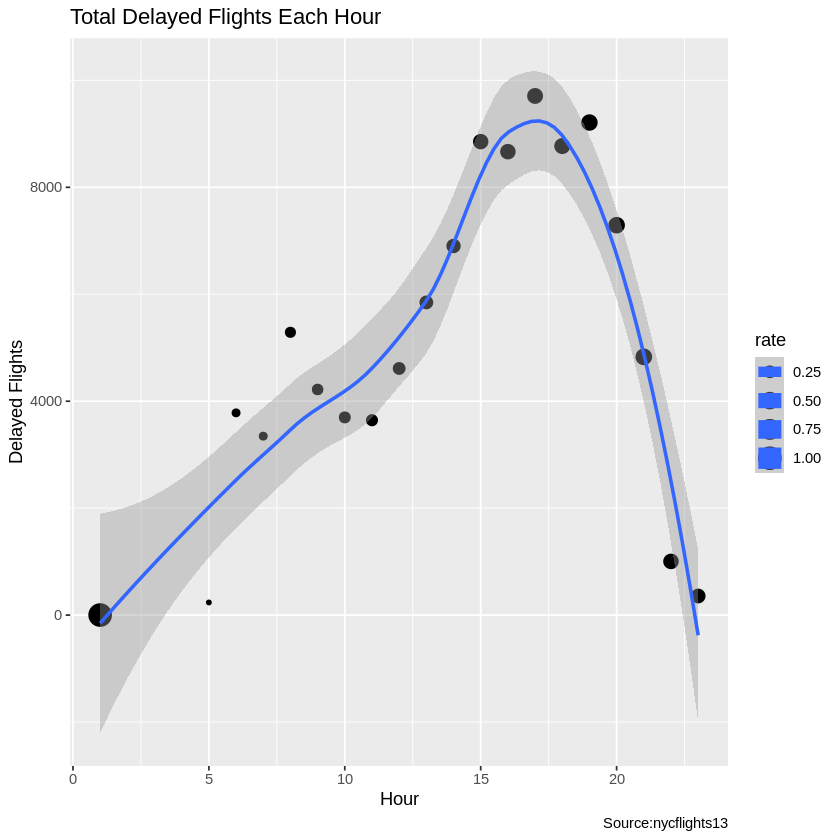

In [ ]:
qplot(hour,delayed_flights , data= delay_hour, geom="point" ,size=rate)+geom_smooth()+labs(x="Hour",y="Delayed Flights",title="Total Delayed Flights Each Hour",caption="Source:nycflights13")

Arranged by rate

In [ ]:
flights %>%
  group_by(hour) %>%
  summarise(total_flights=n(),
            delayed_flights = sum(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),
            rate = round(mean(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),3))%>%
  filter(total_flights > 100) %>%
  arrange(desc(rate)) %>%
  head(10)

hour,total_flights,delayed_flights,rate
<dbl>,<int>,<int>,<dbl>
21,10933,4829,0.442
20,16739,7291,0.436
19,21441,9211,0.430
18,21783,8771,0.403
17,24426,9708,0.398
22,2639,1004,0.381
16,23002,8666,0.378
15,23888,8854,0.372
23,1061,357,0.338


**Summary** : 

> 5 PM had the most delays on both departure and arrival flights with the number of ***9,708*** flights at the rates of ***39.8%*** out of ***24,426*** flights. 

> In addition, 21 PM had the highest rate of delay with the number of ***4,829*** flights at the rates of ***44.2%*** out of ***10,933*** flights. 

> On the other hand, even though most flights happened at 8 AM (***27,242 flights***), it had only ***19.5%*** departure delay(***5,288 flights***).


## 4.Top 5 airlines with the most delays
- Operated more than 1000 flights in the year
- include cancelled flights
- 15 minutes is the criteria for delayed flight
- cancelled flights = dep_time is NA
- % of delayed flights

> Find the airline with most delays / delay rate.

In [ ]:
flights %>%
  inner_join(airlines, by = 'carrier') %>%
  group_by(name) %>%
  summarise(total_flights=n(),
            delayed_flights = sum(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),
            rate = round(mean(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),3)) %>%
  filter(total_flights > 1000) %>%
  arrange(desc(delayed_flights))

name,total_flights,delayed_flights,rate
<chr>,<int>,<int>,<dbl>
ExpressJet Airlines Inc.,54173,20920,0.387
United Air Lines Inc.,58665,16783,0.287
JetBlue Airways,54635,16712,0.306
Delta Air Lines Inc.,48110,11072,0.230
Envoy Air,26397,8745,0.332
American Airlines Inc.,32729,7824,0.240
Endeavor Air Inc.,18460,6353,0.345
US Airways Inc.,20536,4586,0.224
Southwest Airlines Co.,12275,4039,0.330


In [ ]:
delay_rate <- flights %>%
  inner_join(airlines, by = 'carrier') %>%
  group_by(name) %>%
  summarise(total_flights=n(),
            delayed_flights = sum(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),
            rate = round(mean(dep_delay>15|arr_delay>15|is.na(dep_time),na.rm=T),3)) %>%
  filter(total_flights > 1000) %>%
  arrange(desc(rate))

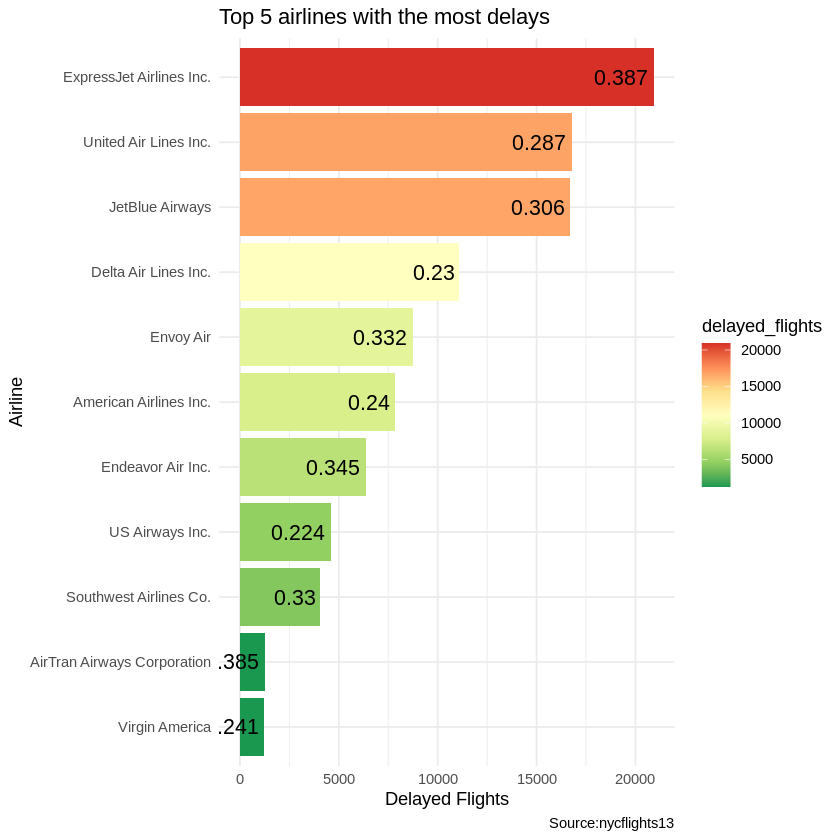

In [ ]:
ggplot(delay_rate) +
  geom_col(aes(delayed_flights,reorder(name,delayed_flights),fill=delayed_flights)) +
  geom_text(aes(y=name, x=delayed_flights,label=rate),hjust=1.1, 
             size=4.5,color='black')+
  theme_minimal()+
  scale_fill_distiller(palette="RdYlGn")+
  labs(x="Delayed Flights",y="Airline",title="Top 5 airlines with the most delays",caption="Source:nycflights13")

Summary :

> ExpressJet Airline has the most frequent delays with the number of 20,920 out of 54,173 flights, which is approximately 38.7%

> US Airways is the best airline in terms of on-time departure and arrival with 22.4% delay out of 20,536 flights.

## 5.Most used aircraft manufacturer and model in NYC in 2013
- Most used aircraft
- Aircraft used for each route

In [ ]:
flights %>%
  inner_join(planes,by='tailnum') %>%
  select(manufacturer,model) %>%
  count(manufacturer,model,sort=T,name='total_flights') %>%
  head(10)

manufacturer,model,total_flights
<chr>,<chr>,<int>
AIRBUS,A320-232,45831
EMBRAER,EMB-145LR,28027
EMBRAER,ERJ 190-100 IGW,23716
EMBRAER,EMB-145XR,14051
BOEING,737-824,13809
BOMBARDIER INC,CL-600-2D24,11807
BOEING,737-7H4,10389
AIRBUS,A319-114,9713
BOEING,757-222,9150



> **Noticed that model A320-232 has different manufacturers, causing the total number of flights to be incorrect*

---



> Change all manufacturer 'AIRBUS INDUSTRIE' to 'AIRBUS'

In [ ]:
planes[planes$manufacturer == 'AIRBUS INDUSTRIE',4] <- 'AIRBUS'



---


> Now, try again

In [ ]:
flights %>%
  inner_join(planes,by='tailnum') %>%
  select(manufacturer,model) %>%
  count(manufacturer,model,sort=T,name='total_flights') %>%
  head(10)


manufacturer,model,total_flights
<chr>,<chr>,<int>
AIRBUS,A320-232,45831
EMBRAER,EMB-145LR,28027
EMBRAER,ERJ 190-100 IGW,23716
EMBRAER,EMB-145XR,14051
BOEING,737-824,13809
BOMBARDIER INC,CL-600-2D24,11807
BOEING,737-7H4,10389
AIRBUS,A319-114,9713
BOEING,757-222,9150


Many result are the same aircraft series ( Ex. Model EMB-145LR and EMB-145XR are the same aircraft series)

Mutate aircraft series in the new column using `str_extract` and query again

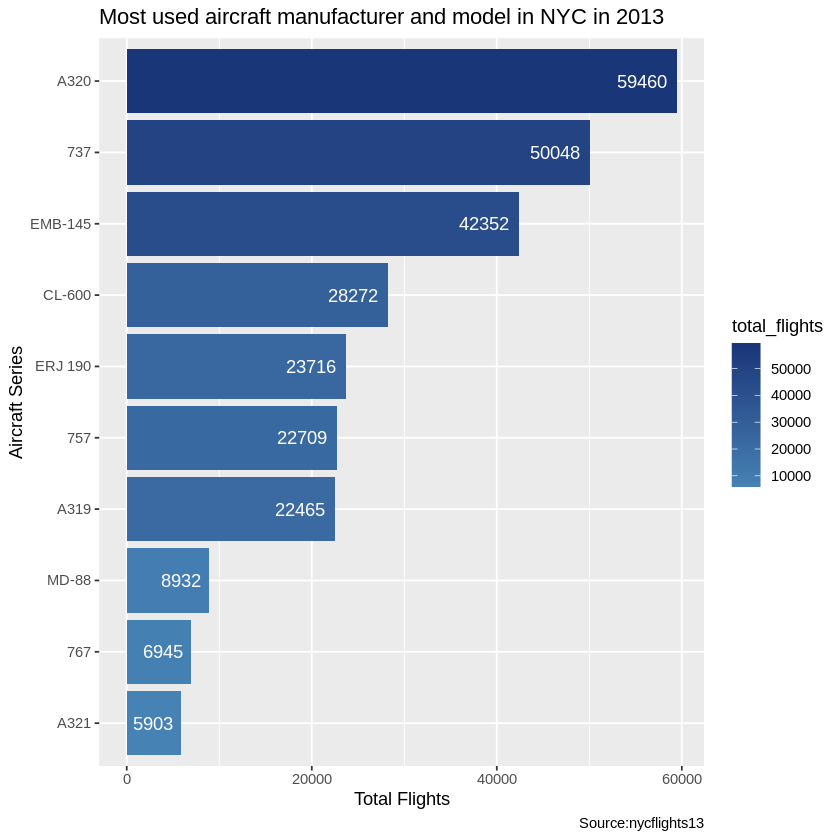

In [ ]:
most_used_ac <- flights %>% 
  inner_join(planes,by='tailnum') %>%
  mutate(serie = case_when(
    grepl("[A-z]+-[0-9]+",model)~str_extract(model, "[A-z]+-[0-9]+"),
    grepl("[A-z]+.[0-9]+",model)~str_extract(model, "[A-z]+.[0-9]+"),
    grepl("[A-z]+.[A-z]+",model)~str_extract(model, "[A-z]+.[A-z]+"),
    grepl("[A-z]+-[A-z]+",model)~str_extract(model, "[A-z]+-[A-z]+"),
    grepl("[A-z0-9]+-[0-9]+",model)~str_extract(model, "[A-z0-9]+"),
    grepl("[0-9]+",model)~str_extract(model, "[0-9]+")
    )) %>% select(manufacturer,serie) %>%
    count(manufacturer,serie,sort= T,name='total_flights') %>% 
    head(10)

  most_used_ac %>%
    ggplot(aes(total_flights,reorder(serie,total_flights),fill=total_flights))+
    geom_col()+
    geom_text(aes(label=total_flights),hjust=1.2,color='white')+
    scale_fill_gradient(low = 'steelblue',high ='#193678')+
    labs(title="Most used aircraft manufacturer and model in NYC in 2013",x="Total Flights",y="Aircraft Series",caption="Source:nycflights13")

> Find the aircraft used for each route.

In [ ]:
(routes_ac <- flights %>%
  inner_join(planes,by='tailnum') %>%
  mutate(serie = case_when(
    grepl("[A-z]+-[0-9]+",model)~str_extract(model, "[A-z]+-[0-9]+"),
    grepl("[A-z]+.[0-9]+",model)~str_extract(model, "[A-z]+.[0-9]+"),
    grepl("[A-z]+.[A-z]+",model)~str_extract(model, "[A-z]+.[A-z]+"),
    grepl("[A-z]+-[A-z]+",model)~str_extract(model, "[A-z]+-[A-z]+"),
    grepl("[A-z0-9]+-[0-9]+",model)~str_extract(model, "[A-z0-9]+"),
    grepl("[0-9]+",model)~str_extract(model, "[0-9]+")
    )) %>%
  select(manufacturer,serie,origin,dest) %>%
  count(origin,dest,serie,name='total_flights',sort=T))


origin,dest,serie,total_flights
<chr>,<chr>,<chr>,<int>
JFK,SFO,757,4099
JFK,LAX,767,4047
LGA,DCA,A319,3936
LGA,BOS,ERJ 190,3773
JFK,LAX,757,3572
JFK,LAX,A320,3445
JFK,MCO,A320,3149
JFK,FLL,A320,2840
LGA,ATL,757,2839


Summary : 
> Airbus model A320-232 is the most used aircraft in NYC in 2013 with the total of 59,460 flights. 



---



# RPostgreSQL

## Install / Load library

In [ ]:
install.packages("RPostgreSQL")
library(RPostgreSQL)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: DBI



## Create connection

In [ ]:
con <- dbConnect(
  drv = RPostgreSQL::PostgreSQL(),
  host = "tiny.db.elephantsql.com",
  dbname = "vagbozel",
  port = 5432,
  user = "vagbozel",
  password = "szzuos79Ed7xrYMpE4E3PQOQjfHDsvM-"
)

## Write data frame to database 

In [ ]:
#dbWriteTable(con,'routes_ac',routes_ac,row.names = FALSE)
#dbWriteTable(con,'most_used_ac',most_used_ac,row.names = FALSE)
dbWriteTable(con,'least_delayed_airlines',least_delayed_airlines,row.names = FALSE)
dbWriteTable(con,'most_delayed_airlines',most_delayed_airlines,row.names = FALSE)
dbWriteTable(con,'longest_routes',longest_routes,row.names = FALSE)

##Query table list

In [ ]:
dbListTables(con)

## Query from database

In [ ]:
dbGetQuery(con,"SELECT * FROM routes_ac limit 5")

In [ ]:
dbGetQuery(con,"SELECT * FROM most_used_ac limit 5")

In [ ]:
dbGetQuery(con,"SELECT * FROM most_delayed_airlines limit 5")

In [ ]:
dbGetQuery(con,"SELECT * FROM least_delayed_airlines limit 5")

In [ ]:
dbGetQuery(con,"SELECT * FROM longest_routes limit 5")

In [ ]:
df <- dbGetQuery(con,"SELECT * FROM routes_ac limit 5")

In [ ]:
df
df[1,]

,origin,dest,model,n
,<chr>,<chr>,<chr>,<int>
1,EWR,ALB,EMB-145LR,306
2,EWR,ALB,EMB-145XR,128
3,EWR,ALB,EMB-145,5
4,EWR,ANC,757-222,6
5,EWR,ATL,A319-114,1411


,origin,dest,model,n
,<chr>,<chr>,<chr>,<int>
1,EWR,ALB,EMB-145LR,306
